In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits as fits
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower
import scipy.optimize as opt
from numpy import linalg as LA

import utils

from utils import bin_l as bin_l
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# functions

In [519]:

def plot_ps(cls, _nside, label):
#     plt.figure(figsize = (10,8));
    
    if len(cls.shape) == 1:
        _ell = np.arange(len(cls)); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2:], '-',label = label );
        
    else:
        _ell = np.arange(len(cls[0])); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[1][2:],label = 'EE');
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2][2:],label = 'BB');
    
    plt.legend(fontsize = 20);

# Public area

In [79]:
Nf = 3; nside = 512; lmax = 1000; Q = 50

In [80]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [75]:
ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [74]:
# def Mask(maps): 
    
#     maps_ma = np.zeros_like(maps)
    
#     if len(maps.shape) == 1:
#         _index = np.arange(len(maps));
#         maps_ma[_index[ali_ma == 0]] = maps[_index[ali_ma == 0]]
        
#     else:
#         _index = np.arange(len(maps[0]))
#         for _i in range(3):
#             maps_ma[_i][_index[ali_ma == 0]] = maps[_i][_index[ali_ma == 0]]

#     return maps_ma

(3, 3, 3145728)

In [218]:
cl_clean_44 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_clean_44GHz_mean_std.npy')

In [17]:
cl_clean_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_clean_95GHz_mean_std.npy')
#shape(4,50)
## mean for E and B, std for E and B;

# SEVEM

In [307]:
total_map = (np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_map_unmasked/total_map_deconv_unmasked_IQU_010.npy'))

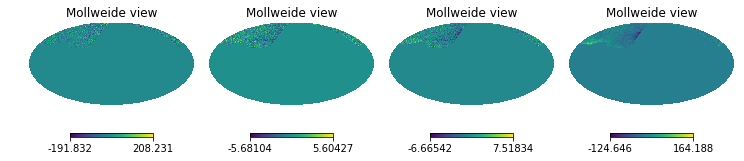

In [326]:
hp.mollview(total_map[0,1], sub = (141));
hp.mollview(total_map[1,1], sub = (142)); 
hp.mollview(total_map[2,1], sub = (143));
hp.mollview(total_map[3,1], sub = (144));

In [499]:
Nf = 4
def Mask_0(maps):
    index0 = np.arange(len(ali_ma));
    mask_index0 = index0[np.where(ali_ma<1)]
    for i in range(Nf):
        for j in range(3):
            maps[i,j][mask_index0] = 0
    
    return maps

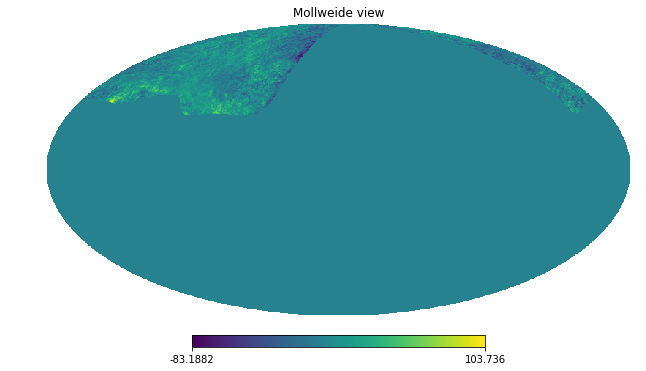

In [350]:
hp.mollview(da3)

In [324]:
methods = ['Powell', 'Nelder-Mead','CG']
# CG 1'17''
# Powell 23.3''
# Nelder-Mead 46.5''
cmb_clean = np.zeros((3, 12*nside**2))
total_map = Mask_0(np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_map_unmasked/total_map_deconv_unmasked_IQU_010.npy'))

for i in range(1,2):
    
    for s in range(1,3): ### Stokes parameter
        
        da1 = total_map[1,s] - total_map[0,s]
        da2 = total_map[2,s] - total_map[1,s]
        da3 = total_map[3,s] - total_map[2,s]
        
        fun_std = lambda x,i,s :np.std(total_map[i,s] - x[0]*da1 - x[1]*da2 -x[2]*da3 )
        
#         fun_std_95 = lambda x,i,s :np.std(total_map[i,s] - x[0]*da1 - x[1]*da2)
#         fun_std_150 = lambda x,i,s :np.std(total_map[i+1,s] - x[0]*da2 - x[1]*da3)
        
        results = opt.minimize(fun_std, (0,0,0), args = (i,s), method = methods[0])
#         results95 = opt.minimize(fun_std_95, (0, 0), args = (i,s), method = methods[0]) 
#         results150 = opt.minimize(fun_std_150, (0, 0), args = (i,s), method = methods[0])
        cmb_clean[s] = total_map[i,s] - results['x'][0]*da1 - results['x'][1]*da2 - results['x'][2]*da3
#         cmb_clean[i, s] = total_map[i,s] - results95['x'][0]*da1 - results95['x'][1]*da2
#         cmb_clean[i+1, s] = total_map[i+1,s] - results150['x'][0]*da2 - results150['x'][1]*da3

In [327]:
results

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 7.98738980e-07, -1.05183342e-02,  1.43144037e-04]])
     fun: 0.43073752902482265
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 3
  status: 0
 success: True
       x: array([-4.40920561e-05, -4.96830520e-01,  1.92519534e-02])

## cmb maps at each frequency

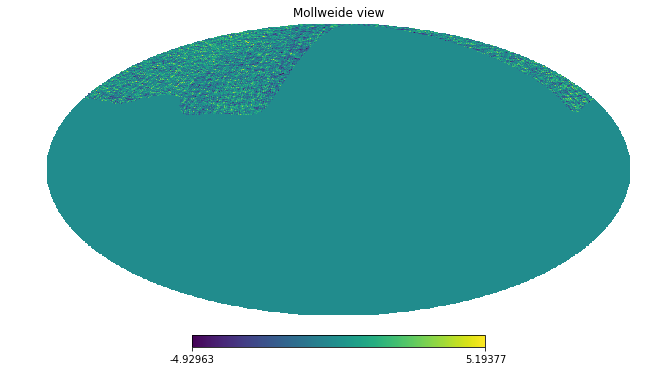

In [329]:
hp.mollview(cmb_clean[1]);

# hp.mollview(Mask(cmb_clean[1][1]), sub = (132)); hp.mollview(Mask(cmb_clean[2][1]), sub = (133))

## PS

In [254]:
cl_95 = hp.anafast(Mask(cmb_clean[1]), lmax = lmax)
cl_150 = hp.anafast(Mask(cmb_clean[2]), lmax = lmax)
cl_353 = hp.anafast(Mask(cmb_clean[2]), lmax = lmax)

cl_95_BB = utils.bin_l(cl_95[2], lmax, Q)
cl_95_EE = utils.bin_l(cl_95[1], lmax, Q)

cl_150_EE = utils.bin_l(cl_150[1], lmax, Q)
cl_150_BB = utils.bin_l(cl_150[2], lmax, Q)

In [159]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [342]:
total_EE_95 = utils.bin_l(total_cl[1], lmax, Q)
total_BB_95 = utils.bin_l(total_cl[2], lmax, Q)

In [331]:
cl_cmb = hp.anafast(cmb_clean, nspec = 3, lmax = lmax)

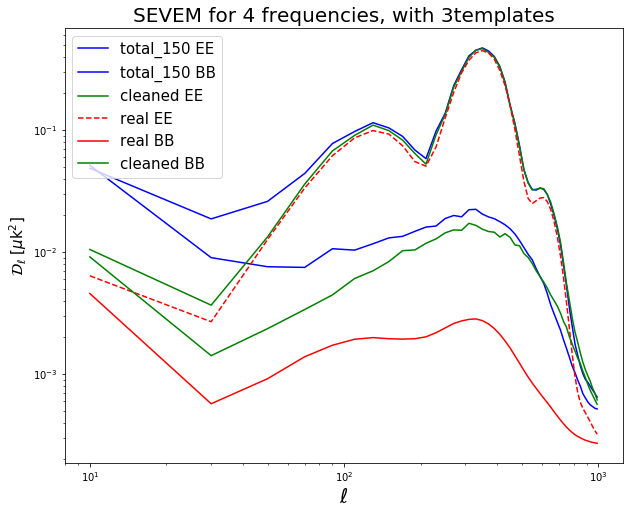

In [344]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height

plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*total_EE_95, 'b-',label = 'total_150 EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*total_BB_95, 'b-',label = 'total_150 BB')


# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_95_EE, 'g--',label = '95 EE')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_150_EE, 'b--',label = '150 EE')
plt.loglog(Ell, el2*utils.bin_l(cl_cmb[1], lmax, Q), 'g', label = 'cleaned EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_clean_44[0]), 'r--', label = 'real EE ')

# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_95_BB, 'g-',label = '95 BB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_150_BB, 'b-',label = '150 BB')

plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_clean_44[1]), 'r-', label = 'real BB ')
plt.loglog(Ell, el2*utils.bin_l(cl_cmb[2], lmax, Q) ,'g', label = 'cleaned BB')

# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(D_B_mean), 'g-', label = 'ABS CMB')

# plt.errorbar(Ell,Ell*(Ell+1)*(D_B_mean)/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*D_B_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='yo',capthick = 0.1)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('SEVEM for 4 frequencies, with 3templates', fontsize = 20)
plt.savefig('/home/jianyao/Ali_maps/results/0227_SEVEM/4_fre_3_templates_with_total.jpg', format = 'jpg')

In [341]:
total_cl = hp.anafast(total_map[2])

# AliCPT Noise

In [240]:
n95 = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_95_G_512.fits')
n150 = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_512.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


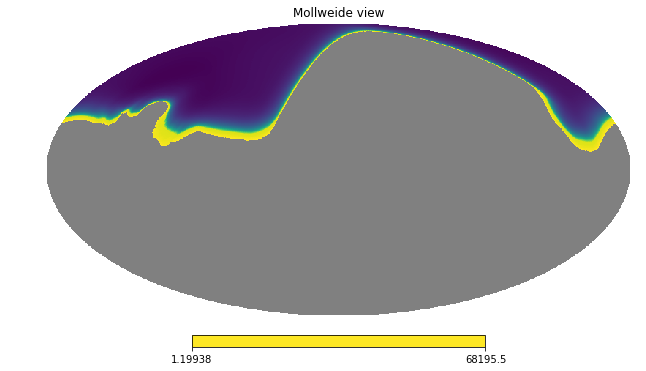

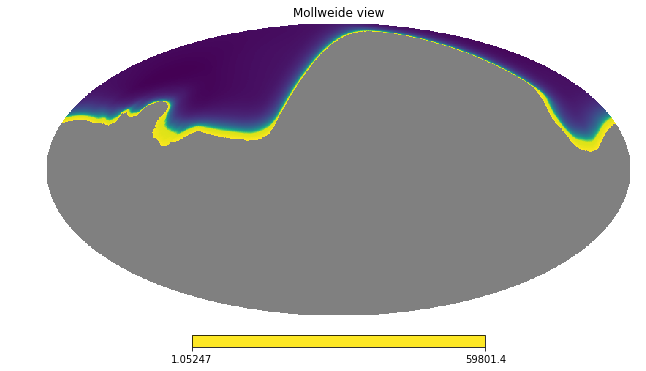

In [245]:
hp.mollview(n150, norm = 'hist')
hp.mollview(n95, norm = 'hist')

In [250]:
mask_all = hp.read_map('/smc/jianyao/Ali_maps/Ali_mask_1024.fits')
mask_wo = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


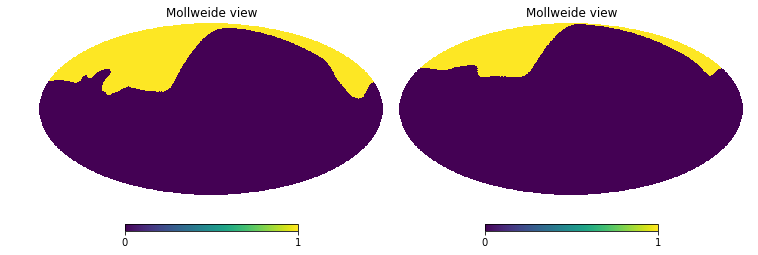

In [249]:
hp.mollview(mask_all, sub = (121)); hp.mollview(mask_wo, sub = (122))

In [251]:
np.sum(mask_wo)/np.sum(mask_all)

0.6148680502948812

# Test SEVEM on PYSM

In [352]:
i = 60
noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)

In [514]:
cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(10), field = None, verbose = False), nside_out = 512)

In [444]:
nu = np.array([95, 150, 353]);nside = 512;
coefficients = convert_units("uK_RJ", "uK_CMB", nu)

def convert_unit(map):
    Nf = len(nu)
    for i in range(0,Nf):
        map[i] = map[i]*coefficients[i]
    return map

sky_config = {'dust':models('d1', nside),
#              'cmb':models('c1', nside),
             'synchrotron' :models('s1', nside)}

sky = pysm.Sky(sky_config)

In [548]:
total = convert_unit(sky.signal()(nu))
# cmb = convert_unit(sky.cmb(nu))

total[0] += (noise_95 + cmb_i);
total[1] += (noise_150 + cmb_i);
total[2] += (noise_353 + cmb_i);

Nf = 3
total_pysm = Mask_0(total)

In [549]:
cmb_new = np.zeros((3, 12*512**2))

In [550]:
for s in range(0,3):
    
    tem1 = total_pysm[1,s] - total_pysm[0,s]
    tem2 = total_pysm[2,s] - total_pysm[1,s] 
    
    fun_std = lambda x :np.std(total_pysm[0,s] - x[0]*tem1 - x[1]*tem2)
        
    results = opt.minimize(fun_std, (0, 0), method = methods[0])
    cmb_new[s] = total_pysm[0,s] - results['x'][0]*tem1 - results['x'][1]*tem2

In [551]:
cl_new = hp.anafast(cmb_new, lmax = lmax + 200)

In [552]:
tcl = hp.anafast(total_pysm[0])

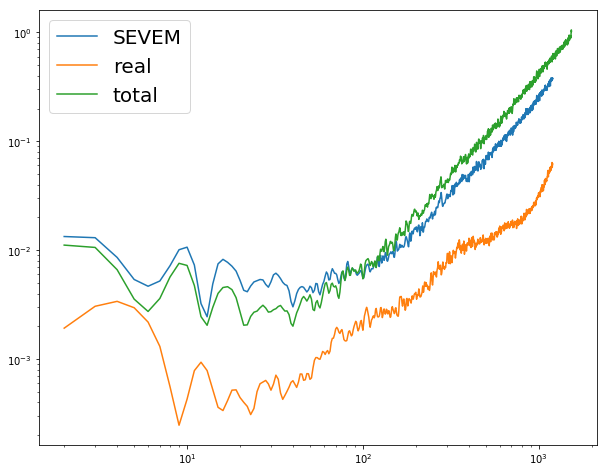

In [572]:
mode = 2
plot_ps(cl_new[mode], _nside = nside, label='SEVEM')
plot_ps(cl_real[mode], _nside = nside, label = 'real')

# plot_ps(cl_real0, _nside = nside)

plot_ps(tcl[mode], _nside = nside, label = 'total')

## ILC

In [555]:
Noise = np.zeros((Nf,3,12*nside**2))
Noise[0] = noise_95;
Noise[1] = noise_150;
Noise[2] = noise_353;

total_Q = np.zeros((Nf, 12*nside**2)) ; total_U = np.zeros((Nf, 12*nside**2))## two frequencies
noise_Q = np.zeros((Nf, 12*nside**2)); noise_U= np.zeros((Nf, 12*nside**2))

for i in range(Nf):
    total_Q[i][mask_index] = total_pysm[i][1][mask_index]
    total_U[i][mask_index] = total_pysm[i][2][mask_index]

    # noise_ILC
    noise_Q[i][mask_index] = Noise[i][1][mask_index]
    noise_U[i][mask_index] = Noise[i][2][mask_index]

Cov_Q = np.zeros((Nf, Nf)); w_Q = np.zeros(Nf)
Cov_U = np.zeros((Nf, Nf)); w_U = np.zeros(Nf)

for i in range(Nf):
    for j in range(Nf):
        Cov_Q[i, j] = np.dot(total_Q[i][mask_index] - np.mean(total_Q[i][mask_index]), total_Q[j][mask_index] - np.mean(total_Q[j][mask_index]))/1.0/len(mask_index)
        Cov_U[i, j] = np.dot(total_U[i][mask_index] - np.mean(total_U[i][mask_index]), total_U[j][mask_index] - np.mean(total_U[j][mask_index]))/1.0/len(mask_index)

Cov_Q_inv = np.linalg.pinv(Cov_Q)
Cov_U_inv = np.linalg.pinv(Cov_U)


for i in range(Nf):
    w_Q[i] = np.sum(Cov_Q_inv[i,:])/np.sum(Cov_Q_inv)
    w_U[i] = np.sum(Cov_U_inv[i,:])/np.sum(Cov_U_inv)

cmb_Q = np.dot(w_Q, total_Q); cmb_U = np.dot(w_U, total_U)
cmb_I = np.zeros_like(cmb_Q);
cmb_ILC_pix = np.row_stack((cmb_I, cmb_Q, cmb_U))

noise_ilc_q = np.dot(w_Q, noise_Q); noise_ilc_u = np.dot(w_U, noise_U)
noise_I = np.zeros_like(noise_ilc_q)
noise_ilc_pix = np.row_stack((noise_I, noise_ilc_q, noise_ilc_u))

cls_ILC_pix = hp.anafast(cmb_ILC_pix, lmax = lmax, nspec = 3)
nl_ilc_pix = hp.anafast(noise_ilc_pix, lmax = lmax, nspec = 3)

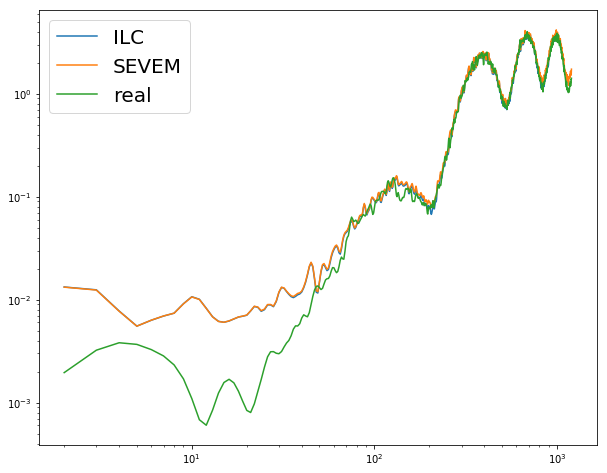

In [569]:
plot_ps(cls_ILC_pix[1] - nl_ilc_pix[1], _nside=nside, label = 'ILC')
plot_ps(cl_new[1], _nside = nside, label='SEVEM')

plot_ps(cl_real[1], _nside = nside, label = 'real')
# plot_ps(tcl[mode], _nside = nside, label = 'total')

## real CMB

In [477]:
cmb_mask = np.zeros((3, 12*512**2))
index = np.arange(len(ali_ma));
mask_index = index[np.where(ali_ma>0)]
for i in range(3):
    cmb_mask[i][mask_index] = cmb_i[i][mask_index]

In [ ]:
cl_real = hp.anafast(cmb_mask,lmax = lmax + 200)

In [386]:
tcl = hp.anafast(total[0,0])